# Overview

The HLS STAC Geoparquet Archive is an unofficial copy of the HLS 2.0 granule STAC item metadata that is generated in the HLS pipeline. The data are stored in two hive-partitioned parquet datasets (one per collection, partitioned by year and month). The parquet files are generated monthly from CMR API Granule queries on the 15th of the following month (e.g. October 2025 files are generated on November 15 2025).

> Warning: This archive is not guaranteed to contain all of the records available in CMR, particularly for the most recent months. If you need the most recent granules do not use this archive!

The parquet files can be accessed from the `nasa-maap-data-store` bucket in AWS S3 (us-west-2):

```
s3://nasa-maap-data-store/file-staging/nasa-map/hls-stac-geoparquet-archive/v2/{collection}/year={year}/month={month}/{collection}-{year}-{month}.parquet
```
where `collection` is either `HLSL30_2.0` (Landsat) or `HLSS30_2.0` (Sentinel-2).

## Usage

### rustac
The [rustac](https://stac-utils.github.io/rustac-py/latest/) package can be used to query the archive via the `DuckdbClient` interface. To use this approach your environment must be configured with AWS credentials that provide `ListBucket` access to the `nasa-maap-data-store` bucket in S3 (this will work in the MAAP hub).

> Note: The HLSL30_2.0 and HLSS30_2.0 collections must be queried separately because the STAC items have slightly different parquet schemas.

In [2]:
import boto3
from rustac import DuckdbClient


client = DuckdbClient(use_hive_partitioning=True)

# configure duckdb to find S3 credentials for listing/reading the files in S3

# on the MAAP HUB
aws_session = boto3.Session()
creds = aws_session.get_credentials().get_frozen_credentials()
client.execute(
    f"""
    CREATE OR REPLACE SECRET secret (
        TYPE S3,
        REGION '{aws_session.region_name}',
        KEY_ID '{creds.access_key}',
        SECRET '{creds.secret_key}',
        SESSION_TOKEN '{creds.token}'
    );
    """
)

# on the MAAP ADE
# client.execute(
#     f"""
#     CREATE OR REPLACE SECRET secret (
#         TYPE S3,
#         PROVIDER credential_chain
#     );
#     """
# )

parquet_href = "s3://nasa-maap-data-store/file-staging/nasa-map/hls-stac-geoparquet-archive/v2/{collection}/**/*.parquet"

datetime = "2025-05-01T00:00:00Z/2025-05-31T23:59:59Z"
bbox = (-90, 45, -85, 50)

hls_l30_items = client.search(
    href=parquet_href.format(collection="HLSL30_2.0"),
    datetime=datetime,
    bbox=bbox,
)
print(f"found {len(hls_l30_items)} HLSL30_2.0 items")

hls_s30_items = client.search(
    href=parquet_href.format(collection="HLSS30_2.0"),
    datetime=datetime,
    bbox=bbox,
)
print(f"found {len(hls_s30_items)} HLSS30_2.0 items")

found 289 HLSL30_2.0 items
found 394 HLSS30_2.0 items


### Example item

The items in the HLS STAC Geoparquet Archive were copied directly from the STAC item JSON files that are produced for every HLS granule (e.g. `https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/HLSS30.020/HLS.S30.T21JXN.2025341T134221.v2.0/HLS.S30.T21JXN.2025341T134221.v2.0_stac.json`).

In [3]:
from pystac import Item

Item.from_dict(hls_s30_items[0])

<Item id=HLS.S30.T15UYR.2025124T165711.v2.0>

## Comparison to CMR API granules

This archive is generated by running granule queries for the HLS collections from the CMR API and represents a snapshot of a dynamic catalog. The archive will be updated with the previous month's granules on the 15th of each month. This is bound to be a partially incomplete copy of the canonical source, but it should have 99% of the full set of granules.

In [4]:
from datetime import datetime, timedelta, UTC
from typing import Any

import duckdb
import pandas as pd
import plotly.express as px
from cmr import GranuleQuery
from itables import init_notebook_mode, show

from hls_stac_parquet.constants import COLLECTION_ORIGIN_DATES, HlsCollection

init_notebook_mode(all_interactive=True)

parquet_path = "s3://nasa-maap-data-store/file-staging/nasa-map/hls-stac-geoparquet-archive/v2/**/*.parquet"


def configure_plotly_theme(fig, height=600):
    """Apply consistent theming to plotly figures for mkdocs"""
    fig.update_layout(
        # Transparent backgrounds for theme compatibility
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        # Responsive sizing
        height=height,
        autosize=True,
        # Font settings - increased sizes for better readability
        font=dict(family="Roboto, sans-serif", size=14, color="#888888"),
        # Title font size
        title_font=dict(size=18, color="#888888"),
        # Legend font size
        legend=dict(font=dict(size=14)),
        # Margins for better spacing
        margin=dict(l=60, r=60, t=80, b=60),
    )

    # Grid and axis styling with larger labels
    fig.update_xaxes(
        gridcolor="rgba(128,128,128,0.2)",
        showline=True,
        linewidth=1,
        linecolor="rgba(128,128,128,0.3)",
        mirror=True,
        title_font=dict(size=15),
        tickfont=dict(size=13),
    )

    fig.update_yaxes(
        gridcolor="rgba(128,128,128,0.2)",
        showline=True,
        linewidth=1,
        linecolor="rgba(128,128,128,0.3)",
        mirror=True,
        title_font=dict(size=15),
        tickfont=dict(size=13),
    )

    # Update facet/subplot annotations (for faceted plots)
    fig.for_each_annotation(lambda a: a.update(font=dict(size=15)))

    return fig

In [5]:
con = duckdb.connect()
con.execute(
    """
    CREATE OR REPLACE SECRET secret (
         TYPE S3,
         PROVIDER CREDENTIAL_CHAIN
    );
    """
)

geoparquet_df = (
    con.execute(
        f"""
        PIVOT read_parquet('{parquet_path}')
        ON collection
        USING count(*)
        GROUP BY year, month
        ORDER BY year, month
        """
    )
    .fetchdf()
    .set_index(["year", "month"])
    .assign(total=lambda x: x["HLSL30_2.0"] + x["HLSS30_2.0"])
)


def cmr_monthly_count(year: int, month: int) -> dict[str, Any]:
    start_datetime = datetime(year=year, month=month, day=1, tzinfo=UTC)
    end_datetime = datetime(
        year=(year if month < 12 else year + 1),
        month=((month + 1) if month < 12 else 1),
        day=1,
    ) - timedelta(seconds=1)

    data = {"year": year, "month": month, "total": 0}
    for collection in list(HlsCollection):
        query = (
            GranuleQuery()
            .collection_concept_id(collection.concept_id)
            .temporal(start_datetime, end_datetime)
        )

        hits = query.hits()
        data[collection.collection_id] = hits
        data["total"] += hits

    return data


cmr_counts = []

dt = COLLECTION_ORIGIN_DATES["HLSL30"]
last_month = datetime.now().replace(day=1, month=datetime.now().month - 1)
while dt < last_month:
    year = dt.year
    month = dt.month
    cmr_counts.append(cmr_monthly_count(year, month))

    dt = datetime(
        year=year if month < 12 else year + 1,
        month=month + 1 if month < 12 else 1,
        day=1,
    )

cmr_df = pd.DataFrame(cmr_counts).set_index(["year", "month"])

diff = cmr_df - geoparquet_df

df = pd.concat(
    [cmr_df, geoparquet_df, diff], axis=1, keys=["CMR", "Geoparquet", "difference"]
)
df = df.swaplevel(0, 1, axis=1).sort_index(axis=1)
df = df.fillna(0)

df.columns.names = ["collection", "source"]

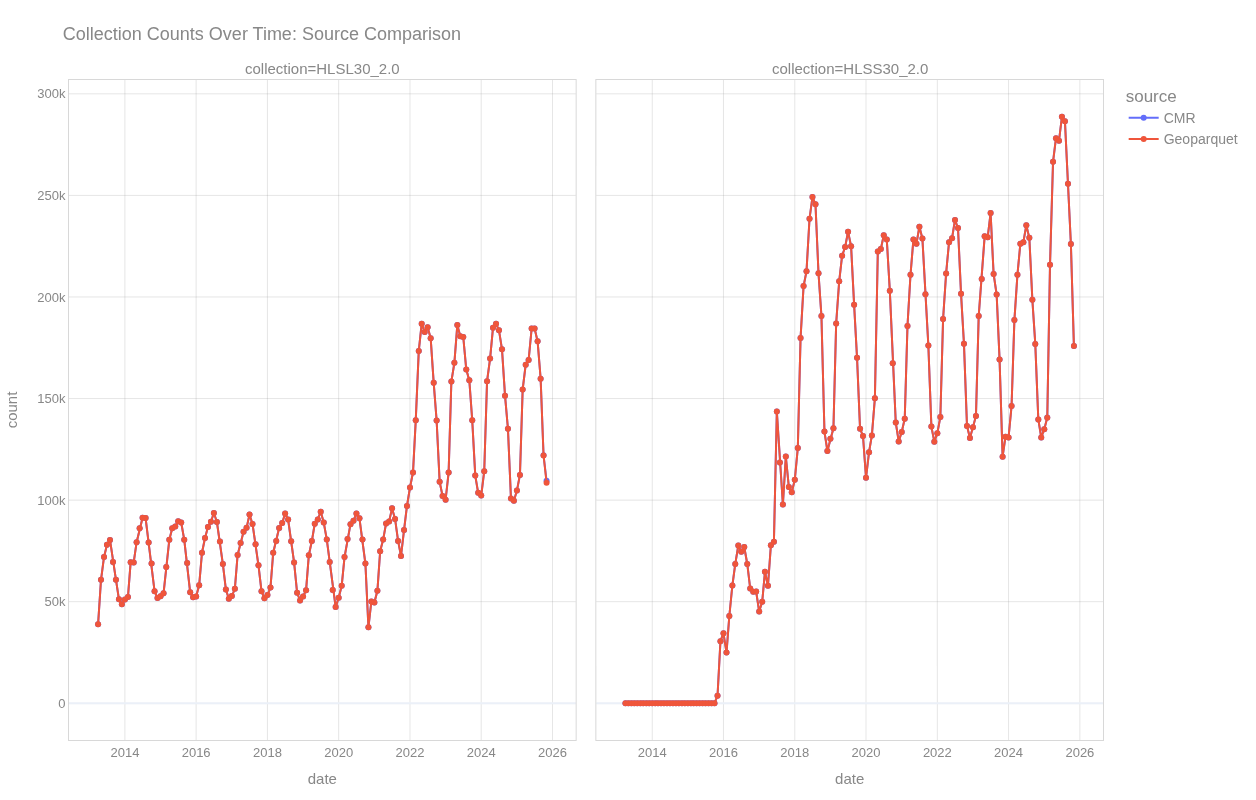

In [6]:
plot_df = df.stack(level=[0, 1], future_stack=True).reset_index(name="count")
plot_df = plot_df[plot_df["collection"] != "total"]

plot_df["date"] = pd.to_datetime(
    plot_df["year"].astype(str) + "-" + plot_df["month"].astype(str) + "-01"
)

fig = px.line(
    plot_df[plot_df["source"] != "difference"],
    x="date",
    y="count",
    color="source",
    facet_col="collection",
    facet_col_wrap=2,
    markers=True,
    title="Collection Counts Over Time: Source Comparison",
    template="plotly_white",
)

fig = configure_plotly_theme(fig, height=800)
fig.show()

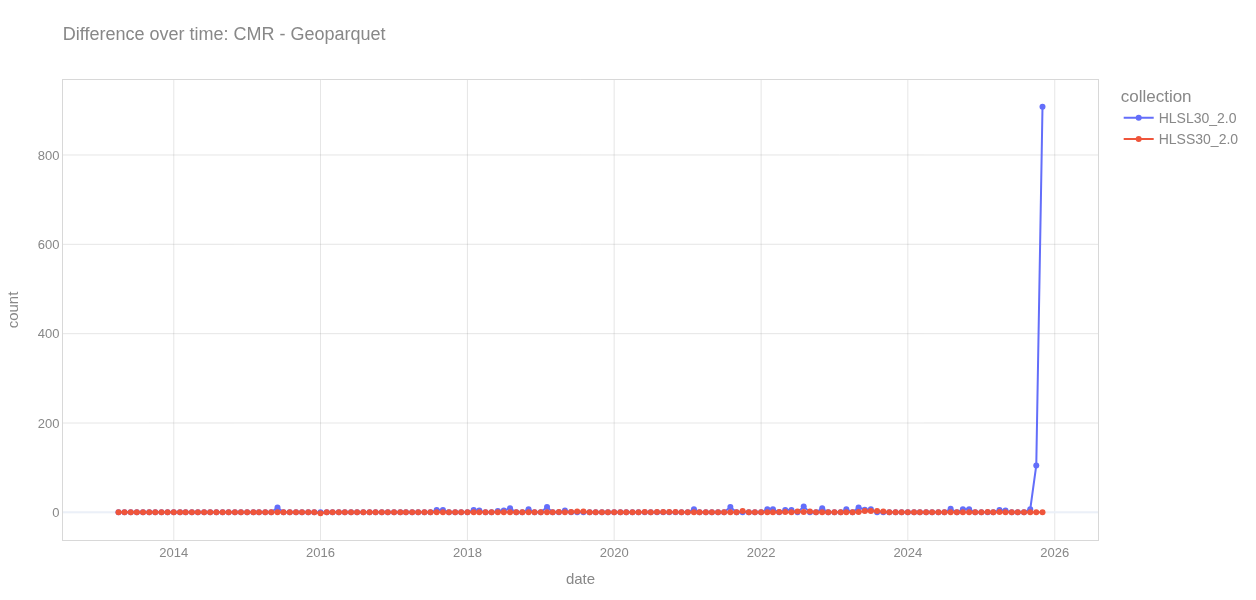

In [7]:
fig = px.line(
    plot_df[plot_df["source"] == "difference"],
    x="date",
    y="count",
    color="collection",
    markers=True,
    title="Difference over time: CMR - Geoparquet",
    template="plotly_white",
)

fig = configure_plotly_theme(fig, height=600)
fig.show()

In [7]:
show(
    df,
    classes="display nowrap compact",
    columnDefs=[{"className": "dt-center", "targets": "_all"}],
    scrollX=True,
    pageLength=12,
    order=[[10, "desc"]],
)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)
